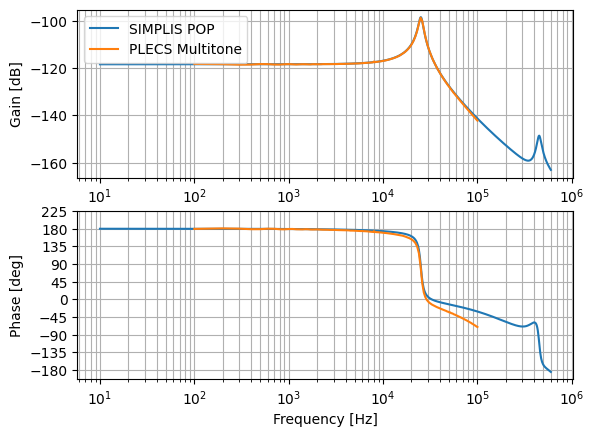

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# open tab-separated file. Strip whitespace from the column names
df1 = pd.read_csv('simplis_export.txt', sep='\t').rename(str.strip, axis='columns')
df2 = pd.read_csv("plecs_export.csv")

fig, ax = plt.subplots(2,1)
# # bode
ax[0].semilogx(df1['freq'], df1['Gain_Gc2vo'], label='SIMPLIS POP')
ax[0].semilogx(df2['Frequency / Hz'], df2['Vm1:Measured voltage'], label='PLECS Multitone')
ax[0].set_ylabel('Gain [dB]')
ax[0].grid(which='both')
ax[0].legend()

ax[1].semilogx(df1['freq'], df1['Phase_Gc2vo'], label='SIMPLIS POP')
ax[1].semilogx(df2['Frequency / Hz'], df2['Vm1:Measured voltage.1'], label='PLECS Multitone')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_yticks(range(-180, 226, 45))
ax[1].grid(which='both')
plt.savefig("SIMPLIS_PLECS_comparison.png")
plt.show()

# df2["Frequency / Hz"]


                   -0.01433
-----------------------------------------------
6.786e-13 s^3 + 9.578e-07 s^2 + 0.3344 s + 1109


              -6.081e+09
--------------------------------------
9.548e+05 s^2 + 6.986e+08 s + 6.67e+14


              -2.237e+09
--------------------------------------
4.806e+05 s^2 + 3.517e+08 s + 1.69e+14



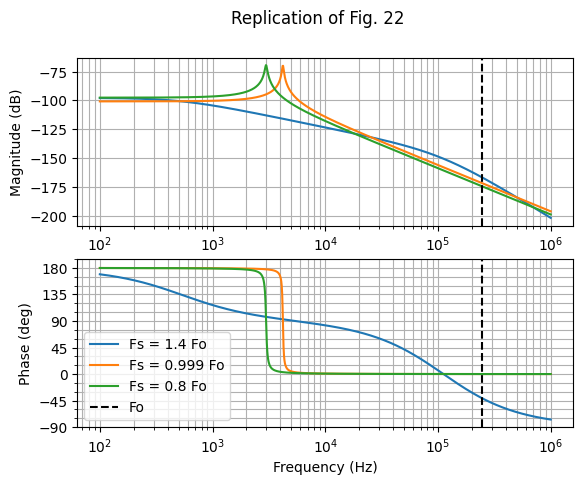

In [24]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
import xmlrpc.client
import pandas as pd
import os

class Params:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    
    @property
    def F_o(self):
        return self.Omega_o / (2 * np.pi)

    @property
    def Omega_o(self):
        return 1 / np.sqrt(self.L_r * self.C_r)
    
    @property
    def Omega_s(self):
        return 2 * np.pi * self.F_s

    @property
    def n(self):
        return self.n_pri / self.n_sec
        
    @property
    def L_n(self):
        return self.L_m / self.L_r

    @property
    def Omega_n(self):
        return self.Omega_s / self.Omega_o

    @property
    def K_d(self):
        """ (7) """
        return 2 / np.pi * self.L_n / (np.sin(self.Omega_n * np.pi / 2))
        """ 2 """
        return -4 * self.V_g / np.pi * 1/(self.Omega_o * self.L_n)

def get_tfs(p: Params):

    L_r = p.L_r
    L_m = p.L_m
    C_r = p.C_r
    C_f = p.C_f
    n = p.n
    R_L = p.R_L
    V_g = p.V_g
    L_n = p.L_n
    F_s = p.F_s
    F_o = p.F_o
    Omega_s = p.Omega_s
    Omega_o = p.Omega_o

    Omega_n = p.Omega_n

    X_eq = Omega_s * L_r - 1 / (Omega_s * C_r) # equivalent reactance (Ohms)
    R_eq = 8 / np.pi**2 * n**2 * R_L # equivalent resistance (Ohms)
    Q = np.sqrt(L_r / C_r) / (n**2 * R_L)

    s = ctrl.TransferFunction([1, 0], [1])

    """ For F_s >= F_o: (14) """
    if F_s >= F_o:
        G_DC = (
            # leading terms
            (V_g / (2 * n)) * (L_n / (Omega_o * Omega_n)) *
            ( # numerator 
                (1/Omega_n**2 - Omega_n**2) * \
                (np.pi**2/8 * Q * L_n)**2 - \
                (L_n + 1 - 1/Omega_n**2) * \
                (2 / Omega_n**2)
            ) / 
            ( # denominator
                np.sqrt(
                    (L_n + 1 - 1 / Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                )
            ) ** 3
        )

        L_e = (1 + Omega_o**2 / Omega_s**2) * L_r

        T_omega_s_to_v_o = G_DC * (X_eq**2 + R_eq**2) / (
            (s**2 * L_e**2 + s*L_e*R_eq + X_eq**2) * (1 + R_L*C_f*s) + \
            R_eq * (s*L_e + R_eq)
        )

    elif F_s < F_o:
        G_DC = (V_g / (2 * n) * L_n / Omega_o *
            ( # numerator 
                (
                    (1/Omega_n**2 - Omega_n**2) * \
                    (np.pi**2/8 * Q * L_n)**2 - \
                    (L_n + 1 - 1/Omega_n**2) * \
                    (2 / Omega_n**2)
                ) * \
                (1 / Omega_n) * \
                (1 / np.sin(np.pi / 2 * Omega_n)) + \
                (
                    (L_n + 1 - 1/Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                ) * \
                (-np.pi/2 * np.cos(np.pi/2 * Omega_n) / np.sin(np.pi/2 * Omega_n))
            ) /
            ( # denominator
                np.sqrt(
                    (L_n + 1 - 1 / Omega_n**2)**2 + \
                    ((1/Omega_n - Omega_n) * np.pi**2/8 * Q * L_n)**2
                )
            ) ** 3
        )

        L_e = L_r * (1 + 1 / Omega_n**2) + L_m * (1 - Omega_n)
        omega_p = np.sqrt(1/(L_e * np.pi**2/(8*n**2) * C_f))
        Q_p = 8 * n / np.pi**2 * R_L * np.sqrt(C_f / L_e)
        # L_e = (1 + Omega_o**2 / Omega_s**2) * L_r + (1 - Omega_s / Omega_o) * L_m
        T_omega_s_to_v_o = G_DC * 1 / (1 + s/(Q_p * omega_p) + (s**2 / omega_p**2))

    else:
        raise ValueError("Invalid switching frequency")

    return T_omega_s_to_v_o



p = Params(**{
    "L_r": 14e-6,  # resonant inductance (H)
    "L_m": 100e-6,  # magnetizing inductance (H)
    "C_r": 30e-9,  # resonant capacitance (F)
    "C_f": 660e-6,   # filter capacitance (F)
    "n_pri": 4,     # number of primary turns
    "n_sec": 1,     # number of secondary turns
    "R_L": 2.3,       # load resistance (Ohms) 
    "V_g": 400,      # input voltage (V)
    "F_s": 1.1e6,   # switching frequency (Hz)
    "C_v_init": 48,
})


for i, F_s in enumerate(np.array([1.4, 0.999, 0.8]) * p.F_o):
    p.F_s = float(F_s)
    T_omega_s_to_v_o = get_tfs(p)
    ratio = p.F_s / p.F_o
    # print the order of the transfer function
    print(T_omega_s_to_v_o)
    ctrl.bode(T_omega_s_to_v_o, dB=True, Hz=True, initial_phase=180,
              omega_limits=(100*2*np.pi, 1e6*2*np.pi), label=f"Fs = {ratio} Fo")

ax = plt.gcf().get_axes()
# plot a vertical line at Fo
ax[0].axvline(p.F_o, color='k', linestyle='--', label='Fo')
ax[1].axvline(p.F_o, color='k', linestyle='--', label='Fo')
plt.legend()
plt.suptitle("Replication of Fig. 22")
plt.show()



In [ ]:

def run_plecs(p: Params):
    s = xmlrpc.client.Server('http://localhost:1080/RPC2')
    sim_name = "llc_open_loop_Tian_Fig_22"
    sim_path = os.path.join(os.getcwd(), f'{sim_name}.plecs')
    s.plecs.load(sim_path)
    # get p.__dict__ as well as all properties
    ModelVars = {**p.__dict__, **{k: getattr(p, k) for k in dir(p) if not k.startswith("__")}}
    # coerce to float
    ModelVars = {k: float(v) for k, v in ModelVars.items()}

    result = s.plecs.analyze(sim_name, 'Multitone Analysis', 
    {"ModelVars": ModelVars, "SolverOpts": {}})
    df = pd.DataFrame({
        "F": result["F"],
        "Gr": result["Gr"][0],
        "Gi": result["Gi"][0],
    })
    df["magnitude"] = 20 * np.log10(np.sqrt(df["Gr"]**2 + df["Gi"]**2))
    df["phase"] = np.arctan2(df["Gi"], df["Gr"]) * (180 / np.pi)
    return df


In [25]:
dfs = {}
for i, (F_s, V_c_o_init) in enumerate(zip(np.array([1.4, 1.0, 0.8]) * p.F_o, [48, 50, 58.3])):
    p.F_s = float(F_s)
    p.C_v_init = float(V_c_o_init)
    df = run_plecs(p)
    dfs[p.F_s] = df

In [23]:
dfs.keys()

dict_keys([343813.97234947764, 245581.4088210555, 196465.12705684442])

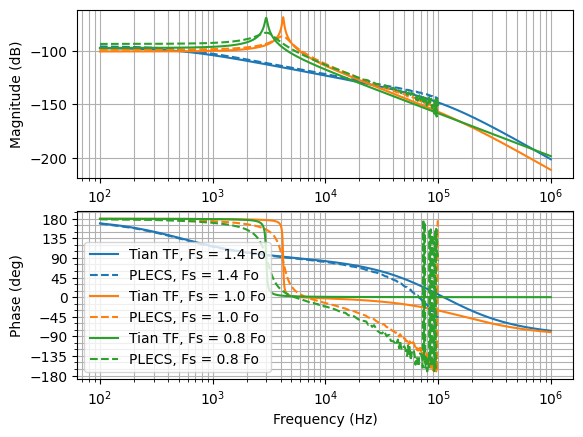

In [26]:

plt.figure()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, F_s in enumerate(np.array([1.4, 1.0, 0.8]) * p.F_o):
    p.F_s = float(F_s)
    T_omega_s_to_v_o = get_tfs(p)
    ratio = p.F_s / p.F_o
    ctrl.bode(T_omega_s_to_v_o, dB=True, Hz=True, initial_phase=180,
            omega_limits=(100*2*np.pi, 1e6*2*np.pi), label=f"Tian TF, Fs = {ratio} Fo",
            color=colors[i])

    ax = plt.gcf().get_axes()
    df = dfs[F_s]
    ax[0].plot(df['F'], df['magnitude'], label=f"PLECS, Fs = {ratio} Fo", color=colors[i], linestyle='--')
    ax[1].plot(df['F'], df['phase'], label=f"PLECS, Fs = {ratio} Fo", color=colors[i], linestyle='--')

plt.legend()
plt.show()
